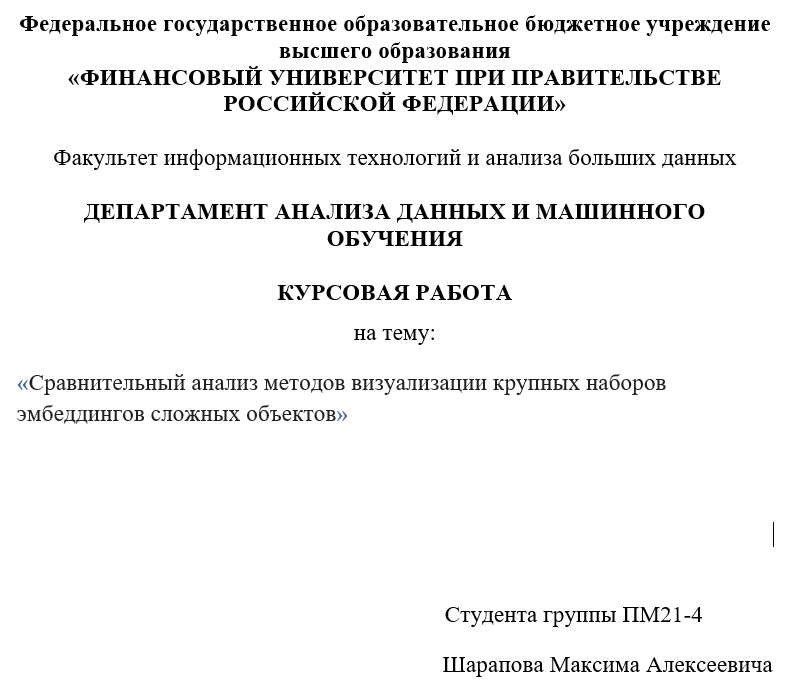

# Введение

Эмбеддинги, или векторы представлений, являются одним из ключевых компонентов современных методов машинного обучения и искусственного интеллекта. Они представляют собой численные векторы, которые кодируют объекты из различных областей, таких как текст, изображения и звуковые сигналы, в многомерное пространство таким образом, чтобы сохранить иерархию и семантические связи между этими объектами.

## Определение и значение эмбеддингов

Эмбеддинги можно представить как функцию f: X -> R^d, где X — это множество объектов, а R^d — пространство с d-мерами, в котором каждый объект из X представлен вектором фиксированной длины d. Важной особенностью эмбеддингов является их способность улавливать семантические и структурные свойства объектов, делая их пригодными для различных задач машинного обучения, таких как классификация, кластеризация и информационный поиск.

В контексте обработки естественного языка (NLP), эмбеддинги слов, такие как Word2Vec, GloVe и FastText, представляют слова в виде векторов, где близкие по смыслу слова находятся близко друг к другу в векторном пространстве. Например, в модели Word2Vec, векторное представление слова w определяется как:

v_w = f(w) в R^d,

где v_w — это вектор размерности d.

Для изображений, Convolutional Neural Networks (CNN) используются для извлечения эмбеддингов, где каждое изображение представлено вектором из последнего скрытого слоя сети:

v_I = g(I) в R^d,

где I — изображение, а g — функция, реализуемая CNN.

## Важность визуализации эмбеддингов

Одной из ключевых задач при работе с эмбеддингами является их визуализация, что позволяет исследователям и практикам интерпретировать и анализировать структуру данных. Визуализация помогает выявить скрытые закономерности, аномалии и кластеры, что особенно важно при работе с крупными наборами данных. Однако визуализация многомерных данных представляет собой значительную сложность из-за необходимости проецирования высокоразмерного пространства в двумерное или трехмерное пространство, понятное для человека.

## Цели и задачи работы

Основной целью данной работы является сравнительный анализ различных методов визуализации эмбеддингов крупных наборов данных. В работе будут рассмотрены как линейные, так и нелинейные методы визуализации, такие как PCA, t-SNE и UMAP. Мы проведем анализ их эффективности, интерпретируемости и вычислительной сложности на примерах текстовых и визуальных эмбеддингов.

##Практическая часть работы

Загрузим датасет

In [ ]:
!wget -O quora.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ERtxpdWOgGQ3HOigqAMHTJjmOE_tWvoF"
!unzip quora.zip
!pip install -q --upgrade nltk gensim bokeh pandas

import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
import pandas as pd

quora_data = pd.read_csv('train.csv')

quora_data

Датасет, который мы загрузили, содержит данные с платформы Quora, где пользователи задают вопросы и получают на них ответы от других пользователей. Датасет содержит следующие столбцы:

1. **id**: Уникальный идентификатор строки в датасете.
2. **qid1**: Уникальный идентификатор вопроса 1.
3. **qid2**: Уникальный идентификатор вопроса 2.
4. **question1**: Текст первого вопроса.
5. **question2**: Текст второго вопроса.
6. **is_duplicate**: Признак дубликата. Принимает значение 1, если вопросы считаются дубликатами, и 0 в противном случае.



Для начала нужно объединить все тексты

In [ ]:
import numpy as np

quora_data.question1 = quora_data.question1.replace(np.nan, '', regex=True)
quora_data.question2 = quora_data.question2.replace(np.nan, '', regex=True)

texts = list(pd.concat([quora_data.question1, quora_data.question2]).unique())
texts[:10]

Для токенизации проще всего воспользоваться `nltk` (он быстрее `spacy`, но может быть хуже в отдельных случаях).

In [ ]:
from nltk.tokenize import word_tokenize

word_tokenize(texts[0])

Приведем все тексты к нижнему регистру и токенизируем их

In [ ]:
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Проверка
assert all(isinstance(row, (list, tuple)) for row in tokenized_texts), \
    "пожалуйста, преобразуйте каждую строку в список токенов"
assert all(all(isinstance(tok, str) for tok in row) for row in tokenized_texts), \
    "пожалуйста, преобразуйте каждую строку в список токенов"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(not is_latin(token) or token.islower() for tokens in tokenized_texts for token in tokens)

In [ ]:
print([' '.join(row) for row in tokenized_texts[:2]])

Тренировка небольшой модели на полученных текстах:

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized_texts,
                 vector_size=32,
                 min_count=5,
                 window=5)

Получить вектор для слова:

In [ ]:
vector = model.wv['anything']
vector

Найти наиболее близкие слова:

In [ ]:
similar_words = model.wv.most_similar('bread')
similar_words

Или даже так:

In [ ]:
model.wv.most_similar(positive=['coder', 'money'], negative=['brain'])

И так, конечно:

In [ ]:
target_vector = model.wv['politician'] - model.wv['power'] + model.wv['honesty']

similar_word = model.wv.similar_by_vector(target_vector, topn=1)
similar_word

#Линейные методы:

### PCA

Простейший линейный метод сокращения размерностей - __P__rincipial __C__omponent __A__nalysis.

В контексте визуализации эмбеддингов метод PCA используется для снижения размерности данных, сохраняя при этом как можно больше информации. Он применяется для проецирования многомерных эмбеддингов на более низкоразмерное пространство (обычно двумерное или трехмерное), что позволяет визуализировать структуру данных.

PCA ищет направления максимальной вариации в данных и представляет их в виде главных компонент. Затем он проецирует исходные данные на эти компоненты, что позволяет нам увидеть, как объекты данных распределены в новом пространстве. В результате мы можем получить графическое представление структуры данных, что помогает нам понять их внутренние закономерности, кластеры и отношения между объектами.

![pca](https://i.stack.imgur.com/Q7HIP.gif)

В результате, можно взять проекции на несколько первых компонент - и сохранить как можно больше информации, сократив размерность.


Визуализируем то, что получилось:

In [ ]:
filtered_tokens = [[token for token in tokens if token in model.wv] for tokens in tokenized_texts]
vectors = [model.wv[token] for tokens in filtered_tokens for token in tokens]

In [ ]:
filtered_tokens=filtered_tokens[:20000]
vectors=vectors[:20000]

In [ ]:
%%time
from sklearn.decomposition import PCA

def get_pca_projection(word_vectors):
    pca = PCA(n_components=2)
    return pca.fit_transform(word_vectors)

word_vectors_pca = get_pca_projection(vectors)

assert word_vectors_pca.shape == (len(vectors), 2), "There must be a 2D vector for each word"
assert max(abs(word_vectors_pca.mean(0))) < 1e-5, "Points must be zero-centered"

import bokeh.models as bm
import bokeh.plotting as pl
from bokeh.io import output_notebook

def draw_vectors(x, y, token, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True):
    """ Draws an interactive plot for data points with auxiliary info on hover """
    output_notebook()


    min_len = min(len(x), len(y), len(token))
    x = x[:min_len]
    y = y[:min_len]
    token = token[:min_len]
    if isinstance(color, str):
        color = [color] * min_len
    else:
        color = color[:min_len]

    data_source = bm.ColumnDataSource({ 'x': x, 'y': y, 'token': token, 'color': color })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[('Token', '@token')]))
    if show:
        pl.show(fig)
    return fig

draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=filtered_tokens)

Этот код визуализирует результаты применения метода PCA к векторным представлениям слов(вопросов). PCA преобразует многомерные векторы слов в двумерное пространство таким образом, чтобы максимально сохранить различия между ними.

Визуализация будет показывать точки на двумерной плоскости, каждая из которых представляет слово. Точки, близкие друг к другу на графике, представляют слова, которые имеют схожие векторные представления в многомерном пространстве. При наведении курсора на точку вы увидите соответствующее слово.

###MDS


Многомерное шкалирование (MDS) - это метод визуализации данных, который позволяет отобразить объекты, представленные в многомерном пространстве, в пространство более низкой размерности, обычно двумерное или трехмерное, с сохранением структурных отношений между ними.

Основная идея MDS заключается в том, чтобы найти такие координаты для каждого объекта, которые были бы наиболее похожими на расстояния между объектами в исходном многомерном пространстве. Другими словами, MDS стремится сохранить относительные расстояния между объектами при проецировании их на новое пространство.

In [ ]:
filtered_tokens_1=filtered_tokens[:3000]
vectors_1=vectors[:3000]

In [ ]:
%%time
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

def get_mds_projection(word_vectors):
    # Вычислить попарные расстояния
    distances = pairwise_distances(word_vectors, metric='cityblock', n_jobs=-1)
    # Применить MDS к матрице расстояний
    mds = MDS(n_components=2, dissimilarity='precomputed')
    return mds.fit_transform(distances)

word_vectors_mds = get_mds_projection(vectors_1)

assert word_vectors_mds.shape == (len(vectors_1), 2), "Должен быть 2D вектор для каждого слова"

In [ ]:
# Визуализация проекции
def draw_vectors_mds(x, y, token, radius=10, alpha=0.25, color='blue',
                     width=600, height=400, show=True):
    """Рисует интерактивный график для точек данных с дополнительной информацией при наведении"""
    output_notebook()

    min_len = min(len(x), len(y), len(token))
    x = x[:min_len]
    y = y[:min_len]
    token = token[:min_len]
    if isinstance(color, str):
        color = [color] * min_len
    else:
        color = color[:min_len]

    # Создание источника данных для графика Bokeh
    data_source = bm.ColumnDataSource({ 'x': x, 'y': y, 'token': token, 'color': color })

    # Создание графика Bokeh
    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    # Добавление инструмента HoverTool для отображения информации о точке при наведении
    fig.add_tools(bm.HoverTool(tooltips=[('Token', '@token')]))
    if show:
        pl.show(fig)
    return fig

# Визуализация MDS проекции
draw_vectors_mds(word_vectors_mds[:, 0], word_vectors_mds[:, 1], token=filtered_tokens_1)

##Вывод

Анализ времени выполнения PCA и MDS на наборе данных из трех тысяч элементов для MDS и двадцати тысяч элементов для PCA позволяет сделать вывод о преимуществе PCA в сравнении с MDS в контексте эффективности вычислений.

На моем наборе данных, состоящем из трех тысяч элементов, PCA завершился в течение нескольких секунд, в то время как MDS требовал почти шести минут для завершения. Это значительное различие во времени выполнения указывает на то, что PCA является более эффективным методом снижения размерности и визуализации данных в случаях, когда данные подходят для линейного преобразования.

Таким образом, при выборе метода для анализа данных, особенно в случае, когда важна скорость выполнения и эффективность использования ресурсов, PCA представляется предпочтительным выбором. В то время как MDS, хотя и может предоставить более точное представление о геометрической структуре данных, может оказаться неэффективным для обработки больших объемов данных из-за длительного времени выполнения.

# Нелинейные методы: t-SNE, UMAP

##T-Distributed Stochastic Neighbor Embedding (t-SNE)

это метод нелинейного снижения размерности, хорошо подходящий для визуализации высокоразмерных данных в пространстве низкой размерности двух или трех измерений.

Что представляет собой алгоритм t-SNE? t-Distributed Stochastic Neighbor Embedding (t-SNE) - это метод снижения размерности. Этот алгоритм использует некоторый стохастический подход для нелинейного снижения размерности набора данных. Он фокусируется на сохранении локальной структуры набора данных в более низкой размерности.

Это помогает нам исследовать высокоразмерные данные, отображая их в низкоразмерное пространство, поскольку локальные структуры сохраняются в наборе данных, мы можем оценить их, построив и визуализировав его в 2D или, возможно, 3D плоскости.

В чем разница между алгоритмом PCA и t-SNE? Несмотря на то, что PCA и t-SNE являются обоюдно однородными алгоритмами, используемыми для снижения размерности набора данных. PCA - это детерминированный алгоритм для снижения размерности, а алгоритм t-SNE - это стохастический нелинейный метод отображения высокоразмерных данных в низкоразмерное пространство. Данные, полученные после снижения размерности с использованием алгоритма t-SNE, обычно используются только для визуализации.

Еще одно отличие заключается в том, что данные t-SNE не подвержены влиянию выбросов, в то время как алгоритм PCA чувствителен к выбросам, потому что методологии, используемые в двух алгоритмах, отличаются. В то время как мы пытаемся сохранить дисперсию данных с помощью алгоритма PCA, мы используем алгоритм t-SNE для сохранения локальной структуры набора данных.

In [ ]:
%%time
from sklearn.manifold import TSNE
import numpy as np

def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, random_state=42)
    return tsne.fit_transform(np.array(word_vectors))

word_vectors_tsne = get_tsne_projection(vectors)

assert word_vectors_tsne.shape == (len(vectors), 2), "There must be a 2D vector for each word"

def draw_vectors_tsne(x, y, token, radius=10, alpha=0.25, color='blue',
                      width=600, height=400, show=True):
    """Draws an interactive plot for data points with auxiliary info on hover"""
    output_notebook()

    # Ensure all arrays have the same length
    min_len = min(len(x), len(y), len(token))
    x = x[:min_len]
    y = y[:min_len]
    token = token[:min_len]
    if isinstance(color, str):
        color = [color] * min_len
    else:
        color = color[:min_len]

    data_source = bm.ColumnDataSource({'x': x, 'y': y, 'token': token, 'color': color})

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[('Token', '@token')]))
    if show:
        pl.show(fig)
    return fig

draw_vectors_tsne(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], token=filtered_tokens)

##UMAP

UMAP (Uniform Manifold Approximation and Projection) — это современный алгоритм для снижения размерности и мощный инструмент анализа данных. Он разработан для обеспечения скорости, аналогичной PCA (Principal Component Analysis), при этом сохраняет богатую информацию о данных, что делает его конкурентоспособным с t-SNE (t-Distributed Stochastic Neighbor Embedding) в отношении качества снижения размерности.

UMAP основывается на теоретических подходах из области топологии и геометрии, что позволяет ему эффективно сохранять как глобальные, так и локальные структуры данных. Основные шаги работы UMAP включают:

Построение графа соседства: На первом этапе UMAP строит граф, в котором узлы представляют точки данных, а ребра соединяют точки, близкие друг к другу.
Оптимизация графа в низкоразмерном пространстве: Граф оптимизируется таким образом, чтобы расстояния между узлами в низкоразмерном пространстве (обычно 2D или 3D) сохраняли структуру изначального многомерного пространства.

In [ ]:
!pip install umap-learn

In [ ]:
from umap import UMAP

In [ ]:
import numpy as np
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook

# Функция для получения проекции UMAP
def get_umap_projection(word_vectors):
    umap = UMAP(n_components=2, random_state=42)
    return umap.fit_transform(np.array(word_vectors))

# Применение UMAP к данным
word_vectors_umap = get_umap_projection(vectors)

assert word_vectors_umap.shape == (len(vectors), 2), "Должен быть 2D вектор для каждого слова"

# Функция для визуализации
def draw_vectors_umap(x, y, token, radius=10, alpha=0.25, color='blue',
                      width=600, height=400, show=True):
    """ Рисует интерактивный график для точек данных с дополнительной информацией при наведении """
    output_notebook()

    # Убедимся, что все массивы имеют одинаковую длину
    min_len = min(len(x), len(y), len(token))
    x = x[:min_len]
    y = y[:min_len]
    token = token[:min_len]
    if isinstance(color, str):
        color = [color] * min_len
    else:
        color = color[:min_len]

    data_source = bm.ColumnDataSource({'x': x, 'y': y, 'token': token, 'color': color})

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[('Token', '@token')]))
    if show:
        pl.show(fig)
    return fig

# Визуализация с использованием UMAP
draw_vectors_umap(word_vectors_umap[:, 0], word_vectors_umap[:, 1], token=filtered_tokens)

#Embedding Projector

Что такое TensorBoard?\
При построении моделей машинного обучения нам приходится проводить множество экспериментов, чтобы улучшить производительность модели. Tensorboard - это инструментарий визуализации машинного обучения, который помогает нам визуализировать такие показатели, как потери и точность данных обучения и валидации, веса и погрешности, графики моделей и т.д. TensorBoard - это инструмент с открытым исходным кодом, созданный компанией Tensorflow, который работает как веб-приложение, полностью предназначенное для работы на локальном компьютере

Использование TensorBoard Embedding Projector, вы можете графически представить высокие размерные вложения. Это может быть полезно для визуализации, изучения и понимания данных и представления эмбедингов

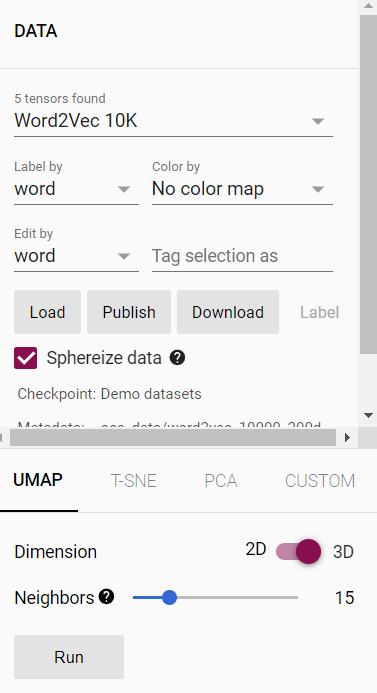

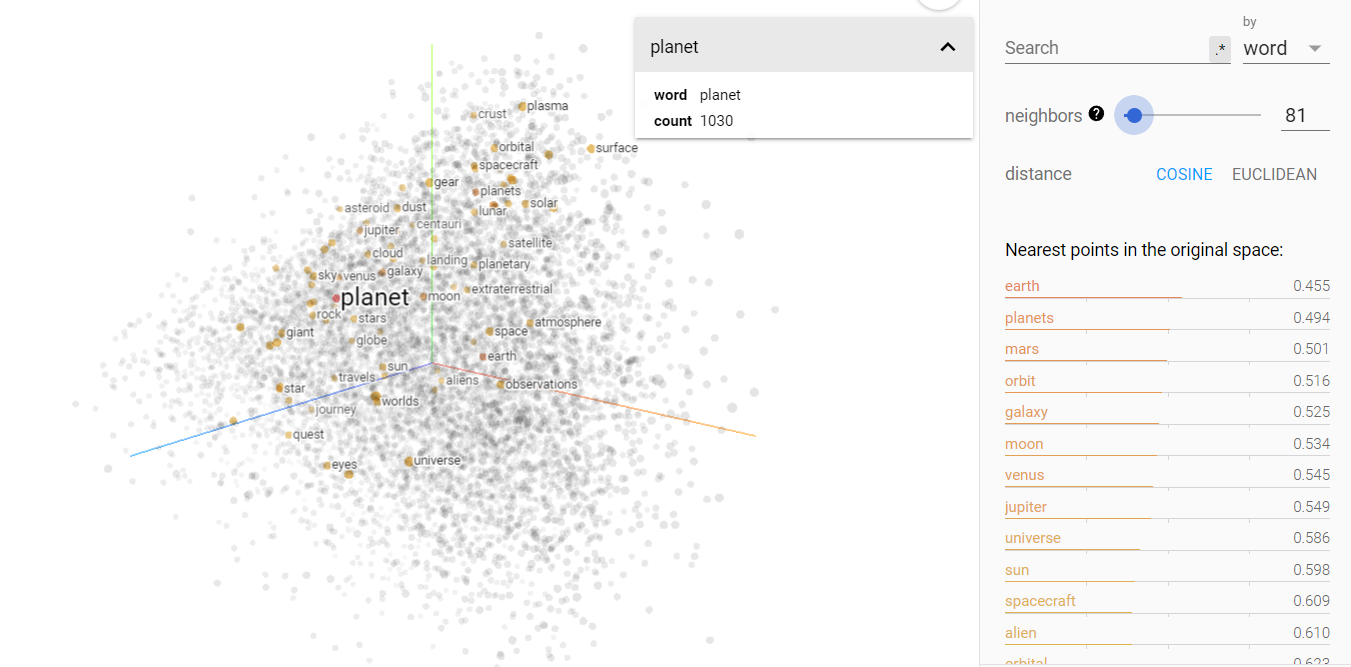

#Выводы

Исходя из исследования, UMAP работает намного быстрее t-SNE, а PCA, благодаря своей простоте, работает намного быстрее, чем UMAP. Поэтому при работе с датасетами очень высокой размерности часто используют следующий пайплайн: сначала применяют простой советский PCA для уменьшения размерности до той величины, с которой сможет за разумное время работать UMAP или t-SNE, а потом уже применяют сам UMAP или t-SNE.